In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image
import skimage 
from skimage.metrics import mean_squared_error as MSE
from skimage.metrics import peak_signal_noise_ratio as PSNR
from alive_progress import alive_bar
import time
from skimage.metrics import structural_similarity as SSIM

# import all functions needed
from core.MeanAndCovar import math_computation
from core.Transform import transform_matrix, transform_pixels
from core.Neigh import extract_neighborhood_info
from core.Estim import likelihood_estimation



# Read input data
original_image = cv2.imread('input_training_lowres/GT19.png')
trimap = cv2.imread('trimap_training_lowres/GT19.png')
ground_truth_trimap = cv2.imread('gt_training_lowres/GT19.png')

#avoid picture being blue
original_image = original_image[...,::-1]
trimap = trimap[...,::-1]
ground_truth_trimap = ground_truth_trimap[...,::-1]

print(trimap.shape)

(580, 800, 3)


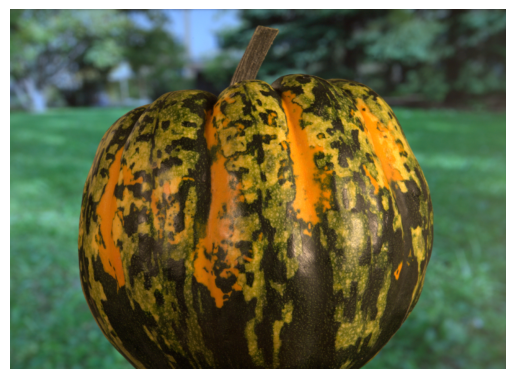

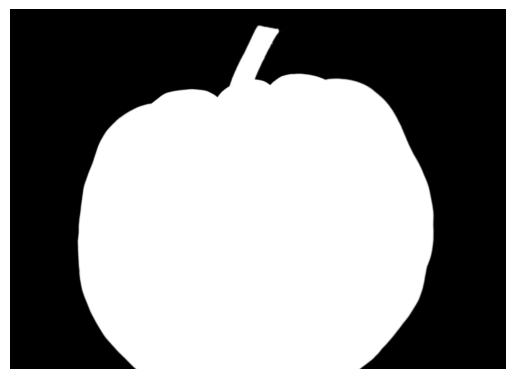

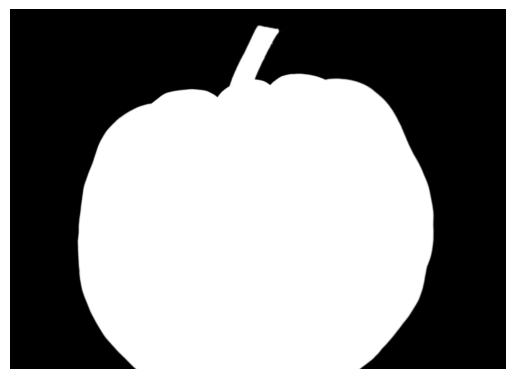

In [2]:
plt.imshow(original_image)
plt.axis('off')  # close axis
plt.show()

plt.imshow(trimap)
plt.axis('off')  # close axis
plt.show()

plt.imshow(ground_truth_trimap)
plt.axis('off')  # close axis
plt.show()

In [3]:
sizeimg_2_dims = original_image.shape[:2]
sizetrimap = trimap.shape[:2]

if sizeimg_2_dims == sizetrimap:
    print("sizechecking: Successfull alignment of image and trimap!")
else:
    print("sizechecking: size not match, asking for new trimap!")
    File, Path = uigetfile(
        ('*.jpg;*.jpeg; *.png; *.gif;*.bmp;*.tiff',
         'Image files (.jpg, .jpeg, .png, .gif, .bmp, .tiff'),
        'Select a new trimap')
    trimap = cv2.imread(Path + File)

if trimap.shape[2] != 1:
    trimap = cv2.cvtColor(trimap, cv2.COLOR_BGR2GRAY)

print(trimap.shape)

sizechecking: Successfull alignment of image and trimap!
(580, 800)


In [4]:
# Convert input data to double ranged from 0 to 1
original_image = original_image.astype(np.double) / 255.0
ground_truth_trimap = ground_truth_trimap.astype(np.double) / 255.0
rows, cols, c = original_image.shape

# Define foreground, background, and unknown areas
fgmask = (trimap == 255).astype(int)
bgmask = (trimap == 0).astype(int)
unknown = (trimap == 128).astype(int)
print(original_image)
print(ground_truth_trimap)
print(rows)
print(cols)
print(c)
print(fgmask)
print(bgmask)
print(unknown)

[[[0.25882353 0.32156863 0.23529412]
  [0.2627451  0.33333333 0.24705882]
  [0.26666667 0.34117647 0.23921569]
  ...
  [0.20392157 0.21176471 0.15686275]
  [0.17647059 0.20392157 0.14509804]
  [0.15294118 0.18431373 0.14509804]]

 [[0.23529412 0.33333333 0.22745098]
  [0.24705882 0.34117647 0.23921569]
  [0.25098039 0.34901961 0.23921569]
  ...
  [0.18431373 0.21960784 0.16862745]
  [0.19215686 0.20392157 0.16078431]
  [0.18039216 0.19215686 0.14901961]]

 [[0.25490196 0.34117647 0.23921569]
  [0.25098039 0.34901961 0.24313725]
  [0.25098039 0.35294118 0.24313725]
  ...
  [0.2        0.23137255 0.18823529]
  [0.18823529 0.21960784 0.18039216]
  [0.17254902 0.20784314 0.16470588]]

 ...

 [[0.2        0.36078431 0.23137255]
  [0.2        0.35686275 0.23921569]
  [0.2        0.36078431 0.25098039]
  ...
  [0.30196078 0.39215686 0.31372549]
  [0.30196078 0.38039216 0.30588235]
  [0.28235294 0.36078431 0.28627451]]

 [[0.2        0.35686275 0.23137255]
  [0.2        0.35686275 0.23529412]


In [5]:
# Initialize alpha matte (background: 0, foreground: 1, unknown area: NaN)
alpha = np.zeros_like(trimap, dtype=float)
alpha[fgmask] = 1
alpha[unknown] = np.nan
alpha = np.repeat(alpha[:, :, np.newaxis], 3, axis=2)

# Initialize F and B matrices
F = np.copy(original_image)
F[~fgmask] = np.nan
B = np.copy(original_image)
B[~bgmask] = np.nan
print(F)
print(B)
# Copy initial values to be used later
F_init = np.copy(F)
B_init = np.copy(B)
alpha_init = np.copy(alpha)

# Set parameters
initial_side_length = 41
increment_for_side_length = 8
sigma_for_gsn = 4
remaining_unknown_pxls = []



[[[0.25882353 0.32156863 0.23529412]
  [0.2627451  0.33333333 0.24705882]
  [0.26666667 0.34117647 0.23921569]
  ...
  [0.20392157 0.21176471 0.15686275]
  [0.17647059 0.20392157 0.14509804]
  [0.15294118 0.18431373 0.14509804]]

 [[0.23529412 0.33333333 0.22745098]
  [0.24705882 0.34117647 0.23921569]
  [0.25098039 0.34901961 0.23921569]
  ...
  [0.18431373 0.21960784 0.16862745]
  [0.19215686 0.20392157 0.16078431]
  [0.18039216 0.19215686 0.14901961]]

 [[0.25490196 0.34117647 0.23921569]
  [0.25098039 0.34901961 0.24313725]
  [0.25098039 0.35294118 0.24313725]
  ...
  [0.2        0.23137255 0.18823529]
  [0.18823529 0.21960784 0.18039216]
  [0.17254902 0.20784314 0.16470588]]

 ...

 [[0.2        0.36078431 0.23137255]
  [0.2        0.35686275 0.23921569]
  [0.2        0.36078431 0.25098039]
  ...
  [0.30196078 0.39215686 0.31372549]
  [0.30196078 0.38039216 0.30588235]
  [0.28235294 0.36078431 0.28627451]]

 [[       nan        nan        nan]
  [       nan        nan        nan]


In [6]:
# First Loop: Iterate over pixels in the unknown area
for i in range(rows):
    for j in range(cols):
        if unknown[i, j]:
            # Initialize parameters
            side_length = initial_side_length
            increment = increment_for_side_length

            # Calculate the number of foreground and background pixels required
            num_fg_pxls = 0
            num_bg_pxls = 0
            min_fg_pxls = 200
            min_bg_pxls = 200
            max_side_length = 75

            # Iterate to find neighborhood information
            for num_iterations in range(max_side_length):
                if ((num_fg_pxls >= min_fg_pxls) and (num_bg_pxls >= min_bg_pxls)) or (side_length > max_side_length):
                    break

                # Get neighborhood information
                fg_neighb, bg_neighb, fg_weights, bg_weights, initial_alpha = extract_neighborhood_info(
                    F_init, B_init, alpha_init, i, j, side_length, sigma_for_gsn)

                # Calculate the number of foreground and background pixels in the neighborhood
                num_fg_pxls = (np.count_nonzero(~np.isnan(fg_neighb))) / 3
                num_bg_pxls = (np.count_nonzero(~np.isnan(bg_neighb))) / 3

                # Increment window size
                side_length = side_length + increment

            # Store remaining unknown pixels if information is insufficient
            if side_length > max_side_length:
                remaining_unknown_pxls.append([i, j])
                continue

            # Estimate alpha, F, B values for pixels with enough information
            fg_weights = transform_matrix(fg_weights, fg_neighb)
            bg_weights = transform_matrix(bg_weights, bg_neighb)
            pxls_fg = transform_pixels(fg_neighb, fg_neighb)
            pxls_bg = transform_pixels(bg_neighb, bg_neighb)
            F_covar, B_covar, B_mean, F_mean = math_computation(
                pxls_fg, pxls_bg, bg_weights, fg_weights)
            print(F_covar)
            print(B_covar)
            print(F_covar.size)
            print(B_covar.size)
            print(F_mean)
            print(B_mean)
            C = original_image[i, j, :]
            C = C.reshape((3, 1))
            max_iterations = 50
            min_likelihood = 1e-6
            sigma_C = 0.01
            F_mean = F_mean.T
            B_mean = B_mean.T
            F_element, B_element, alpha_element = likelihood_estimation(
                C, initial_alpha, F_mean, B_mean, F_covar, B_covar,
                sigma_C, max_iterations, min_likelihood)

            F_element[np.isnan(F_element)] = 0
            B_element[np.isnan(B_element)] = 0

            F[i, j, :] = F_element
            B[i, j, :] = B_element
            alpha[i, j, :] = alpha_element



[[nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[0.00750388 0.00227721 0.00058445]
 [0.00227721 0.00255758 0.00213403]
 [0.00058445 0.00213403 0.00223719]]
9
9
[nan nan nan]
[0.21749134 0.26784592 0.21244587]


C:\Users\Administrator\cms2_python\core\MeanAndCovar.py:9: RuntimeWarning: invalid value encountered in scalar divide
  mean_value[channel - 1] = np.sum(certain_ground[(channel - 1), :] * weight) / whole_weight
C:\Users\Administrator\cms2_python\core\MeanAndCovar.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  covar = np.dot(np.dot(weight * shift, shift.T), 1 / whole_weight)


LinAlgError: SVD did not converge

In [ ]:
# Second Loop: Iterate over remaining unknown pixels
for k in range(len(remaining_unknown_pxls)):
    i = remaining_unknown_pxls[k][0]
    j = remaining_unknown_pxls[k][1]

    side_length = initial_side_length
    increment = increment_for_side_length
    num_fg_pxls = 0
    num_bg_pxls = 0
    min_fg_pxls = 200
    min_bg_pxls = 200
    max_side_length = 80

    # Get neighborhood information for remaining pixels
    for num_iterations in range(max_side_length):
        if ((num_fg_pxls >= min_fg_pxls) and (num_bg_pxls >= min_bg_pxls)) or (side_length > max_side_length):
            break

        fg_neighb, bg_neighb, fg_weights, bg_weights, initial_alpha = extract_neighborhood_info(
            F, B, alpha, i, j, side_length, sigma_for_gsn)
        num_fg_pxls = (np.sum(~np.isnan(fg_neighb))) / 3
        num_bg_pxls = (np.sum(~np.isnan(bg_neighb))) / 3
        side_length = side_length + increment

    fg_weights = transformMatrix(fg_weights, fg_neighb)
    bg_weights = transformMatrix(bg_weights, bg_neighb)
    pxls_fg = transformPixels(fg_neighb, fg_neighb)
    pxls_bg = transformPixels(bg_neighb, bg_neighb)

    # Handle remaining pixels with insufficient information
    if side_length >= max_side_length:
        if num_fg_pxls > num_bg_pxls:
            alpha[i, j, :] = 1
            F_covar, B_covar, B_mean, F_mean = math_computation(
                pxls_fg, pxls_bg, bg_weights, fg_weights)
            F[i, j, :] = F_mean
            continue
        elif num_fg_pxls < num_bg_pxls:
            alpha[i, j, :] = 0
            F_covar, B_covar, B_mean, F_mean = math_computation(
                pxls_fg, pxls_bg, bg_weights, fg_weights)
            B[i, j, :] = B_mean
            continue
    else:
        # Estimate alpha, F, B values for pixels with enough information
        F_covar, B_covar, B_mean, F_mean = math_computation(
            pxls_fg, pxls_bg, bg_weights, fg_weights)

        C = original_image[i, j, :]
        C = C.reshape((3, 1))
        max_iterations = 50
        min_likelihood = 1e-6
        sigma_C = 0.01
        F_mean = F_mean.T
        B_mean = B_mean.T
        F_element, B_element, alpha_element = likelihood_estimation(
            C, initial_alpha, F_mean, B_mean, F_covar, B_covar,
            sigma_C, max_iterations, min_likelihood)

        F_element[np.isnan(F_element)] = 0
        B_element[np.isnan(B_element)] = 0

        F[i, j, :] = F_element
        B[i, j, :] = B_element
        alpha[i, j, :] = alpha_element

alpha_1 = cv2.cvtColor(alpha, cv2.COLOR_BGR2GRAY)
ground_truth_trimap = cv2.cvtColor(ground_truth_trimap, cv2.COLOR_BGR2GRAY)
PSNR = cv2.PSNR(alpha_1, ground_truth_trimap)
MSE = ((alpha_1 - ground_truth_trimap) ** 2).mean()
F[np.isnan(F)] = 0
B[np.isnan(B)] = 0

# Display results
cv2.imshow('Trimap', trimap)
cv2.imshow('Our Result', alpha)
cv2.imshow('Ground Truth', ground_truth_trimap)
cv2.imshow('Original Image', original_image)
cv2.imshow('Foreground', F)
cv2.imshow('Background', B)
print(f'The PSNR of Bayesian matting is: {PSNR:.5f}')
print(f'The MSE of Bayesian matting is: {MSE:.5f}')
print(f'Running Time of Bayesian: {toc}')
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
a = 6
b = (a - 1) / 2
print(b)